# CNN - CIFAR10 - Data Augmentation

In [2]:
# First, import TF and get its version.
import tensorflow as tf
tf_version = tf.__version__

# Check if version >=2.0.0 is used
if not tf_version.startswith('2.'):
    print('\033[91m' + 'WARNING: TensorFlow >= 2.0.0 will be used in this course.\nYour version is {}'.format(tf_version) + '.\033[0m')
else:
    print('\033[92m' + 'OK: TensorFlow >= 2.0.0' + '.\033[0m')

OK: TensorFlow >= 2.0.0.


## Loading the packages

In [14]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import utils
from sklearn.metrics import confusion_matrix
from keras.models import Model

%matplotlib inline

Define a function to plot some images from CIFAR and load the dataset.

170498071/170498071 [==============================] - 6s 0us/step


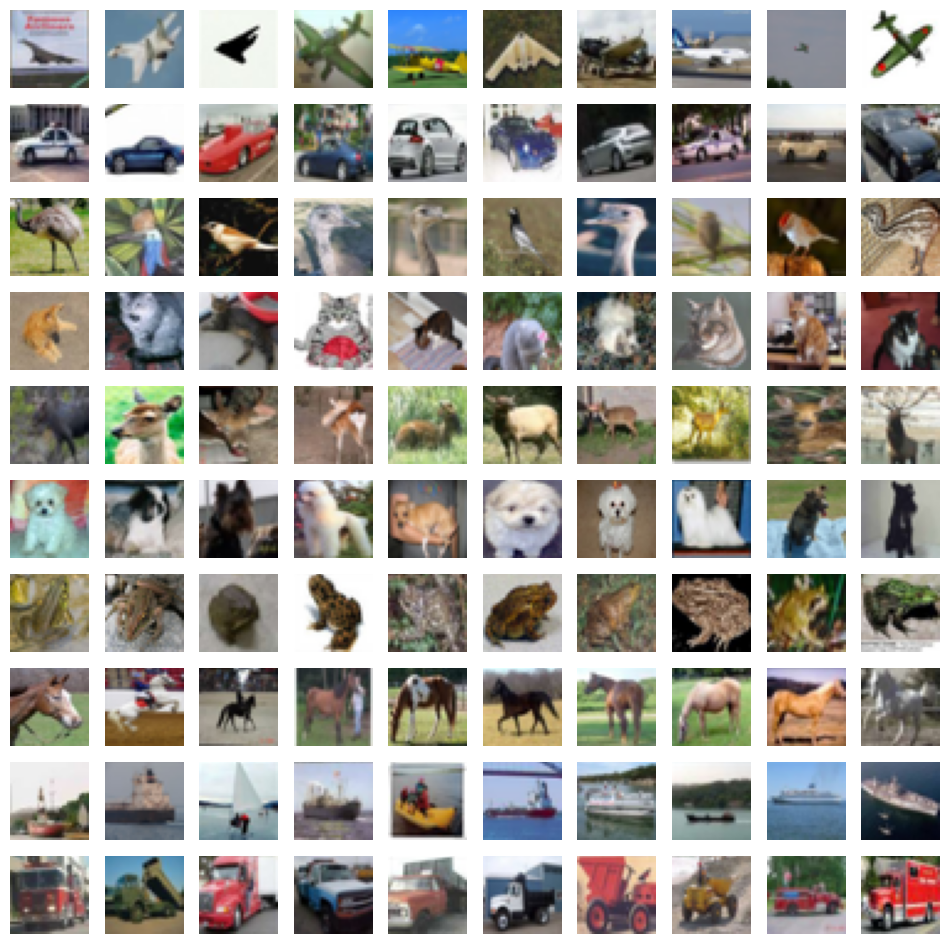

training input shape :  (50000, 32, 32, 3)
training output shape:  (50000, 1)
testing input shape  :  (10000, 32, 32, 3)
testing output shape :  (10000, 1)


In [4]:
def show_imgs(X,y):
    plt.figure(1, figsize=(12,12))
    k = 0
    for i in range(0,10):
        for j in range(0,10):
            while y[k] != i: k += 1
            plt.subplot2grid((10,10),(i,j))
            plt.imshow(X[k])
            plt.axis('off')
            k += 1
    plt.show()

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
show_imgs(X_test, y_test)
print('training input shape : ', X_train.shape)
print('training output shape: ', y_train.shape)
print('testing input shape  : ', X_test.shape)
print('testing output shape : ', y_test.shape)

### Preprocessing data
After loading and splitting the data, we need to preprocess them by reshaping them into the shape the network expects and scaling them so that all values are in the \[0, 1\] interval.

In [5]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

50000 train samples
10000 test samples


The target values of the network are supposed to be 1-hot targets. Now the `y_train` is an array with scalar values as in `[5 0 4 1 ...]` and it should be a 1-hot array `Y_train` as in :

`[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]...]`

Note the change of capital letter in the `Y_train` to denote, per convention, an array with multiple dimensions.

In [6]:
n_classes = 10
Y_train = utils.to_categorical(y_train, n_classes)
Y_test = utils.to_categorical(y_test, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## Define the network
The neural network will be a CNN. Follow the structure given in the exercise 1.

In [7]:
# Define a CNN with the following structure : CONV(32F,same)-RELU-CONV(32F,same)-RELUMAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE.

cnn = Sequential()

# CONV(32F,same)-RELU
cnn.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
cnn.add(Activation('relu'))

# CONV(32F,same)-RELU
cnn.add(Conv2D(32, (3, 3), padding='same'))
cnn.add(Activation('relu'))

# MAXP(2)
cnn.add(MaxPooling2D(pool_size=(2, 2)))

# CONV(32F,same)-RELU
cnn.add(Conv2D(32, (3, 3), padding='same'))
cnn.add(Activation('relu'))

# MAXP(2)
cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the tensor output before the Dense layer
cnn.add(Flatten())

# DENSE
cnn.add(Dense(512))
cnn.add(Activation('relu'))

# Output layer for 10 classes with softmax activation
cnn.add(Dense(10, activation='softmax'))

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248      
                                                        

## Compile and train the network

When compiling the model, we need to specify the loss function, the optimizer and the metrics we want to track during the training. In Keras, we need to call the methods `compile()` and `fit()`. We will train through E epochs, using batches of size B, as specified in the exercise 1.

- The `categorical_crossentropy` loss is relevant for multiclass, single-label classification problem. Categorical is used because there are 10 classes to predict from. If there were 2 classes, we would have used `binary_crossentropy`.
- The `adam` optimizer is an improvement over SGD(Stochastic Gradient Descent). The optimizer is defining the update rule for the weights of the neurons during backpropagation gradients.

In [8]:
E = 10
B = 128

cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
log = cnn.fit(X_train, Y_train, batch_size=B, epochs=E, verbose=1, validation_data=(X_test, Y_test))

Epoch 1/10
391/391 [==============================] - 10s 11ms/step - loss: 1.4370 - accuracy: 0.4839 - val_loss: 1.1413 - val_accuracy: 0.5951
Epoch 2/10
391/391 [==============================] - 3s 8ms/step - loss: 1.0231 - accuracy: 0.6411 - val_loss: 0.9447 - val_accuracy: 0.6717
Epoch 3/10
391/391 [==============================] - 3s 8ms/step - loss: 0.8443 - accuracy: 0.7054 - val_loss: 0.8562 - val_accuracy: 0.7037
Epoch 4/10
391/391 [==============================] - 3s 8ms/step - loss: 0.7230 - accuracy: 0.7480 - val_loss: 0.8299 - val_accuracy: 0.7175
Epoch 5/10
391/391 [==============================] - 4s 9ms/step - loss: 0.6071 - accuracy: 0.7880 - val_loss: 0.8247 - val_accuracy: 0.7179
Epoch 6/10
391/391 [==============================] - 3s 8ms/step - loss: 0.4984 - accuracy: 0.8257 - val_loss: 0.8453 - val_accuracy: 0.7201
Epoch 7/10
391/391 [==============================] - 3s 8ms/step - loss: 0.3820 - accuracy: 0.8676 - val_loss: 0.8665 - val_accuracy: 0.7342
Epoc

## Evaluate the network

We can do this at three levels: (1) plot of the loss during the training phase, (2) overall accuracy evaluation on test set and (3) per class evaluation with confusion matrix on test set.

### Loss and accuracy evolution during training
This can be done first looking at the history of the training (output of the `fit()` function).

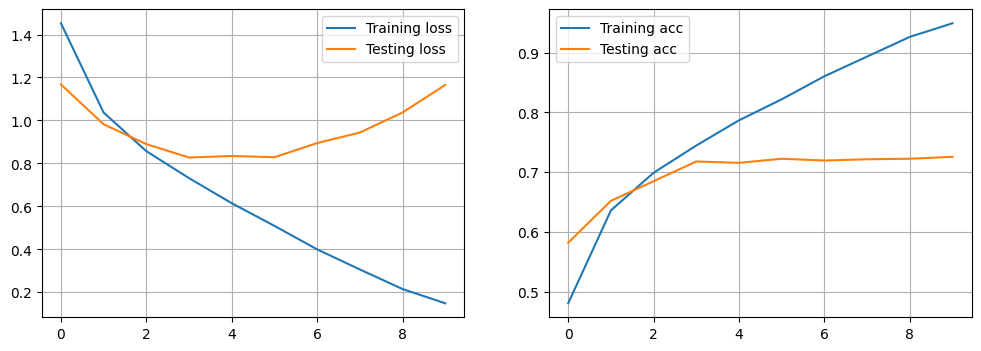

In [22]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

### Model evaluation
We can compute the overall performance on test set calling the `evaluate()` function on the model. The function returns the loss and the metrics used to compile the models.

In [23]:
loss_test, metric_test = cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

Test loss: 1.1652249097824097
Test accuracy: 0.7257000207901001


### Confusion matrix
We can call the `predict_classes()` function to get the predicted classes. The output of this function is an array with the predicted class labels as in `[5 0 4 1 ...]`. The output array of ground truth `y_test` and the predicted classes can then be fed to the `confusion_matrix()` function of [sklearn metrics package](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix).

In [24]:
predict_x=cnn.predict(X_test)
pred=np.argmax(predict_x,axis=1)


confusion_matrix(y_test, pred)

313/313 [==============================] - 1s 2ms/step


array([[801,  17,  44,  16,  25,   9,  11,  10,  40,  27],
       [ 23, 843,   4,  11,   1,  10,   8,   5,  24,  71],
       [ 66,   4, 626,  65,  73,  65,  51,  36,   9,   5],
       [ 23,   9,  72, 543,  58, 171,  56,  43,  16,   9],
       [ 23,   4,  65,  76, 657,  38,  38,  88,   8,   3],
       [ 20,   4,  39, 176,  38, 614,  24,  74,   7,   4],
       [  3,   6,  63,  67,  33,  25, 776,  12,   8,   7],
       [ 24,   2,  23,  32,  53,  39,   4, 812,   4,   7],
       [ 94,  31,  11,  15,   6,   7,   6,   9, 793,  28],
       [ 41,  80,  12,  15,   4,   9,   3,  26,  18, 792]])

## Data Augmentation

Overfitting can be caused by having networks with too many parameters that are trained on too few samples. Through training, the model learns *by hart* and generalizes poorly.

**Data augmentation** takes the approach of generating artificially more training data from existing training samples. For images, data augmentation is performed via a number of random transformations that yield believable-looking images. The goal is that at training time, the model will not see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the ```ImageDataGenerator``` instance.

- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation pipelines, one for train set, one for test set
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3, height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X_train, Y_train, batch_size=B)
val_batches = gen.flow(X_test, Y_test, batch_size=B)

Don't forget to reset your network (by defining it again). You need then to compile the network and train it. The call to the `fit()` function has to be replaced by a call to `fit_generator()` and using the data flow defined above.

In [27]:
# Compile and train the network
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
log = cnn.fit(batches, steps_per_epoch=len(X_train)//B, epochs=E, validation_data=val_batches, validation_steps=len(X_test)//B)

Epoch 1/10
390/390 [==============================] - ETA: 0s - loss: 0.4835 - accuracy: 0.8295

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


390/390 [==============================] - 46s 107ms/step - loss: 0.4835 - accuracy: 0.8295 - val_loss: 0.8290 - val_accuracy: 0.7298
Epoch 2/10
390/390 [==============================] - 37s 95ms/step - loss: 0.4491 - accuracy: 0.8411 - val_loss: 0.8218 - val_accuracy: 0.7433
Epoch 3/10
390/390 [==============================] - 42s 108ms/step - loss: 0.4473 - accuracy: 0.8430 - val_loss: 0.8323 - val_accuracy: 0.7358
Epoch 4/10
390/390 [==============================] - 42s 108ms/step - loss: 0.4223 - accuracy: 0.8514 - val_loss: 0.8558 - val_accuracy: 0.7325
Epoch 5/10
390/390 [==============================] - 36s 93ms/step - loss: 0.3993 - accuracy: 0.8583 - val_loss: 0.8683 - val_accuracy: 0.7366
Epoch 6/10
390/390 [==============================] - 37s 94ms/step - loss: 0.3833 - accuracy: 0.8658 - val_loss: 0.8151 - val_accuracy: 0.7440
Epoch 7/10
390/390 [==============================] - 37s 95ms/step - loss: 0.3829 - accuracy: 0.8650 - val_loss: 0.8362 - val_accuracy: 0.7466


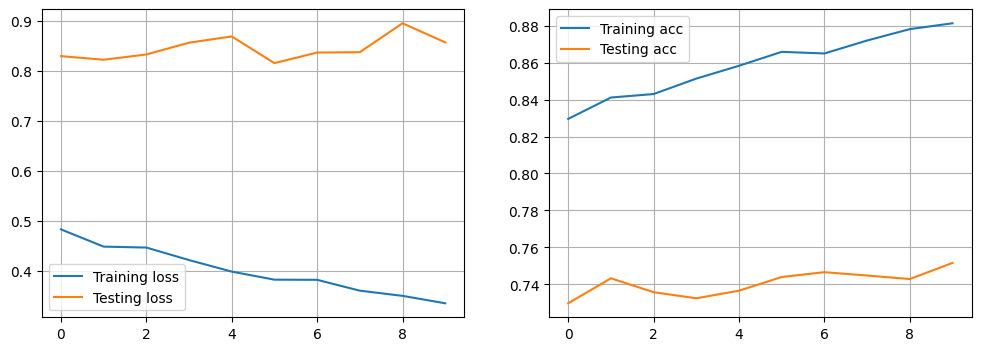

In [28]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [29]:
loss_test, metric_test = cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

Test loss: 0.8611338138580322
Test accuracy: 0.7702999711036682


In [30]:
# Define the data augmentation pipelines, one for train set, one for test set
gen = ImageDataGenerator(rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest' )

batches = gen.flow(X_train, Y_train, batch_size=B)
val_batches = gen.flow(X_test, Y_test, batch_size=B)

In [31]:
# Compile and train the network
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
log = cnn.fit(batches, steps_per_epoch=len(X_train)//B, epochs=E, validation_data=val_batches, validation_steps=len(X_test)//B)

Epoch 1/10
390/390 [==============================] - 47s 116ms/step - loss: 0.6957 - accuracy: 0.7629 - val_loss: 0.8246 - val_accuracy: 0.7240
Epoch 2/10
390/390 [==============================] - 38s 98ms/step - loss: 0.6613 - accuracy: 0.7713 - val_loss: 0.8076 - val_accuracy: 0.7280
Epoch 3/10
390/390 [==============================] - 43s 111ms/step - loss: 0.6383 - accuracy: 0.7805 - val_loss: 0.7742 - val_accuracy: 0.7376
Epoch 4/10
390/390 [==============================] - 37s 96ms/step - loss: 0.6267 - accuracy: 0.7835 - val_loss: 0.7822 - val_accuracy: 0.7359
Epoch 5/10
390/390 [==============================] - 53s 137ms/step - loss: 0.6146 - accuracy: 0.7878 - val_loss: 0.7721 - val_accuracy: 0.7407
Epoch 6/10
390/390 [==============================] - 32s 82ms/step - loss: 0.5937 - accuracy: 0.7946 - val_loss: 0.7548 - val_accuracy: 0.7440
Epoch 7/10
390/390 [==============================] - 34s 88ms/step - loss: 0.5910 - accuracy: 0.7962 - val_loss: 0.7669 - val_accura

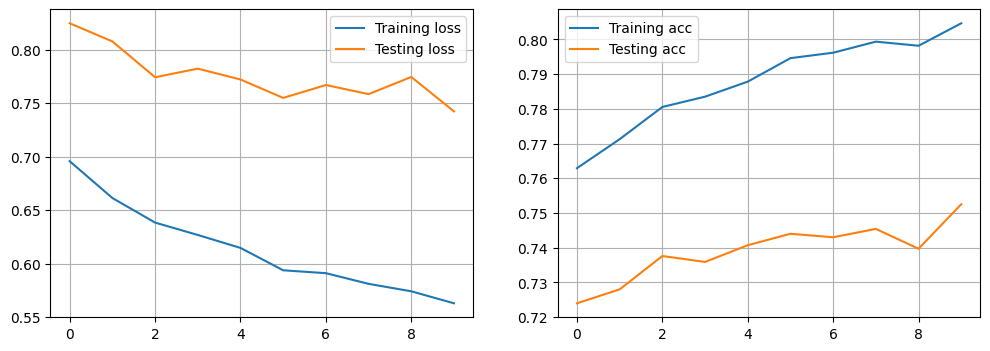

In [32]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [33]:
loss_test, metric_test = cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

Test loss: 0.6647191643714905
Test accuracy: 0.7924000024795532


### Table of results

DA v1:
1. Rotation range: 8 degrees
2. Width shift range: 0.08 (fraction of total width)
3. Shear range: 0.3 (shear angle in radians)
4. Height shift range: 0.08 (fraction of total height)
5. Zoom range: 0.08 (random zoom range for images)  

DA v2:
1. Rotation range: 15 degrees
2. Width shift range: 0.1 (fraction of total width)
3. Height shift range: 0.1 (fraction of total height)
4. Horizontal flip: True (randomly flip inputs horizontally)
5. Zoom range: 0.2 (random zoom range for images)
6. Fill mode: 'nearest' (method used to fill in newly created pixels during transformations)

| CNN | Architecture description | Acc. train | Acc. test |
|-----|--------------------------|------------|-----------|
|  No DA | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.9493  | 0.7257 |
|  With DA v1 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.8813  | 0.77 |
|  With DA v2 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.8047  | 0.79 |

## Findings
Without data augmentation, the loss increases over time, meaning the model suffers from severe overfitting.
Using data augmentation, the model gives better performance and overfits less. However, the training time is considerably longer.

# Exercise 2

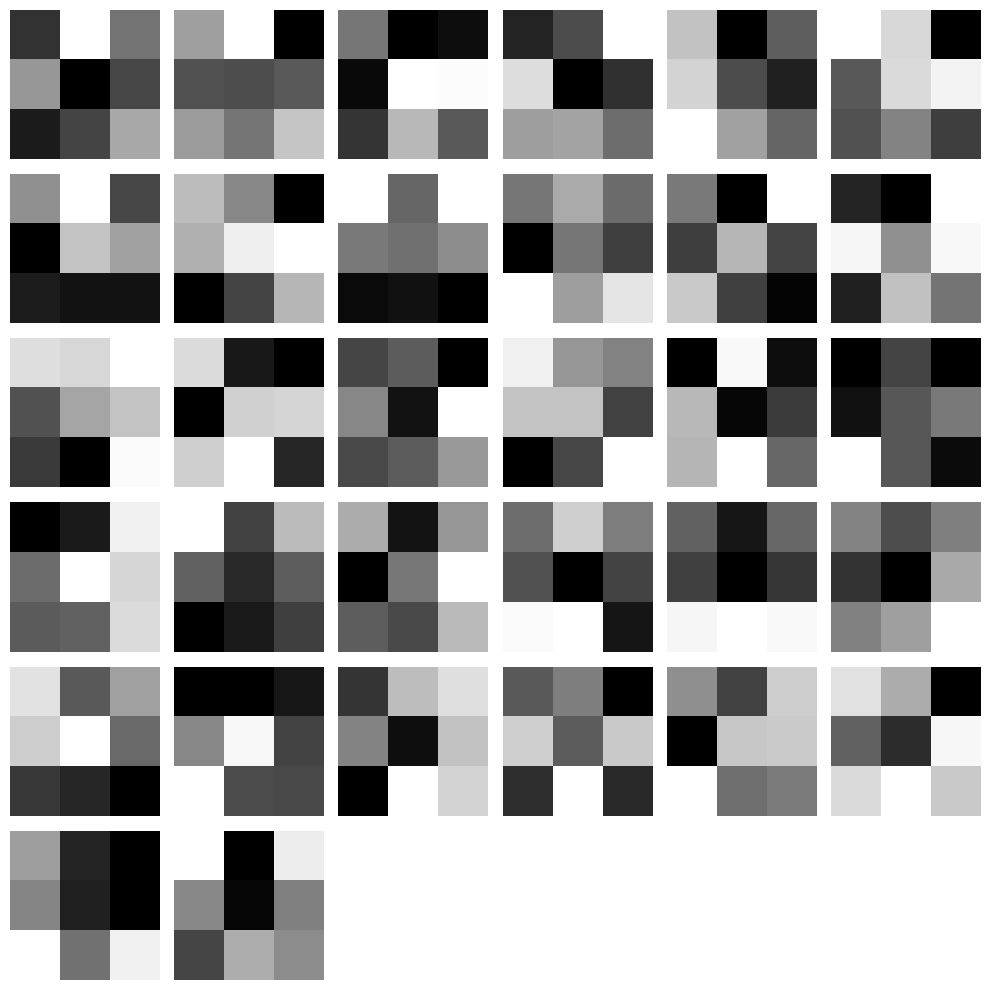

In [13]:
# Extracting the layer weights
layer = cnn.get_layer(name='conv2d_2')
filters, biases = layer.get_weights()

# Normalize filter values between 0 and 1 for visualization
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Number of filters and their dimensions
num_filters = filters.shape[3]

# Plotting the filters
num_cols = int(np.sqrt(num_filters)) if np.sqrt(num_filters).is_integer() else int(np.sqrt(num_filters)) + 1
fig, axes = plt.subplots(nrows=num_cols, ncols=num_cols, figsize=(10, 10))

filter_index = 0
for i in range(num_cols):
    for j in range(num_cols):
        ax = axes[i, j]
        # Only plot if there's a filter left to plot (for non-perfect squares)
        if filter_index < num_filters:
            f = filters[:, :, :, filter_index]
            filter_index += 1
            ax.imshow(f[:, :, 0], cmap='gray')  # Change channel index if needed
            ax.axis('off')
        else:
            ax.axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 444ms/step


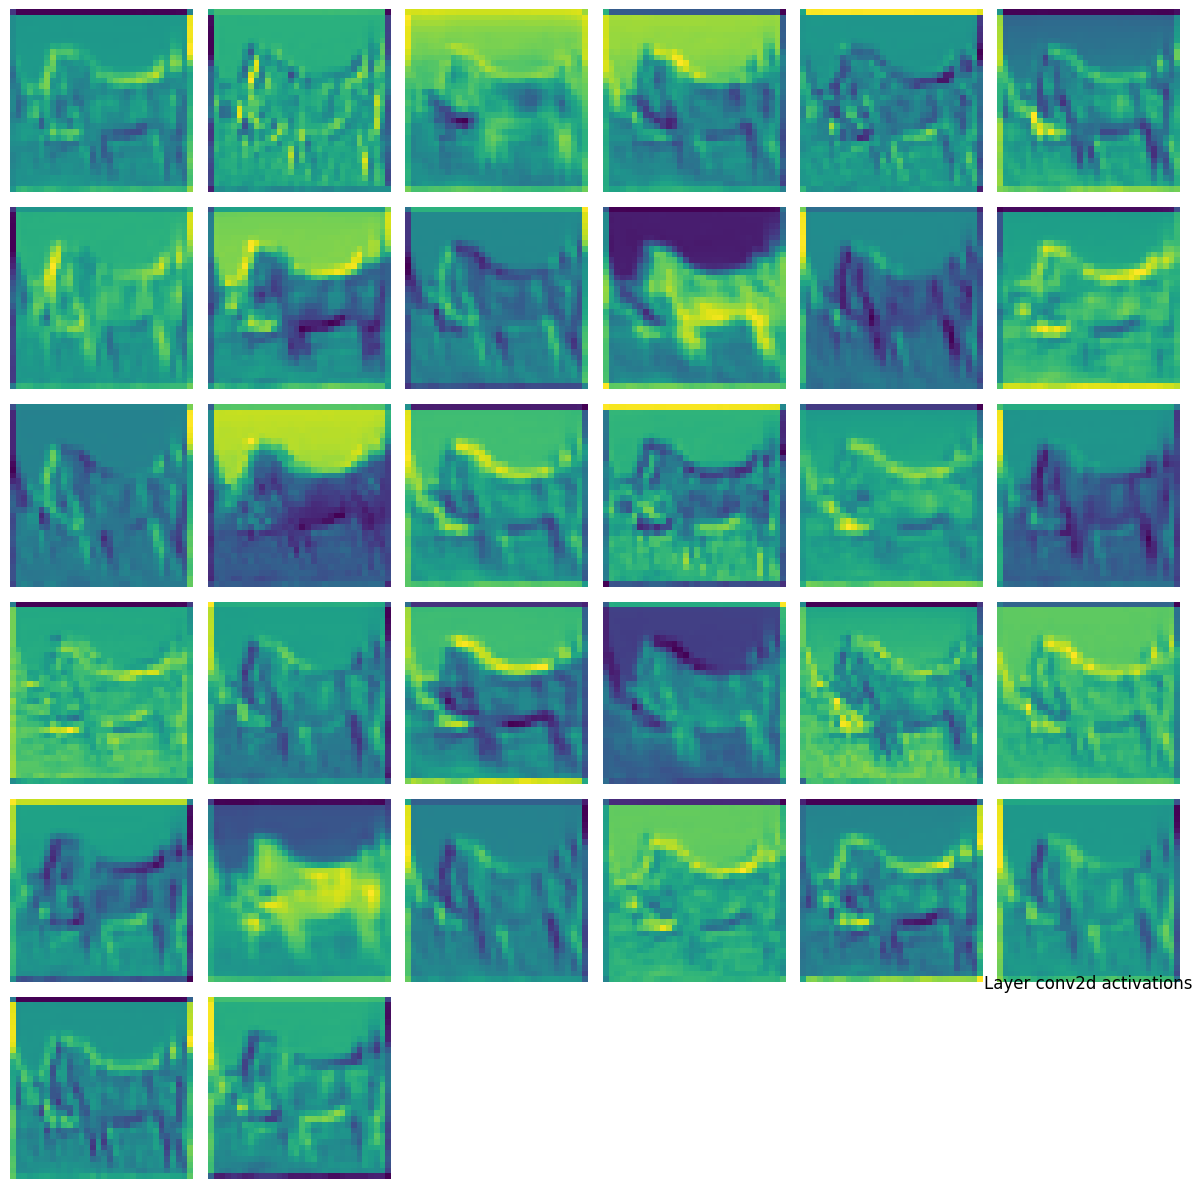

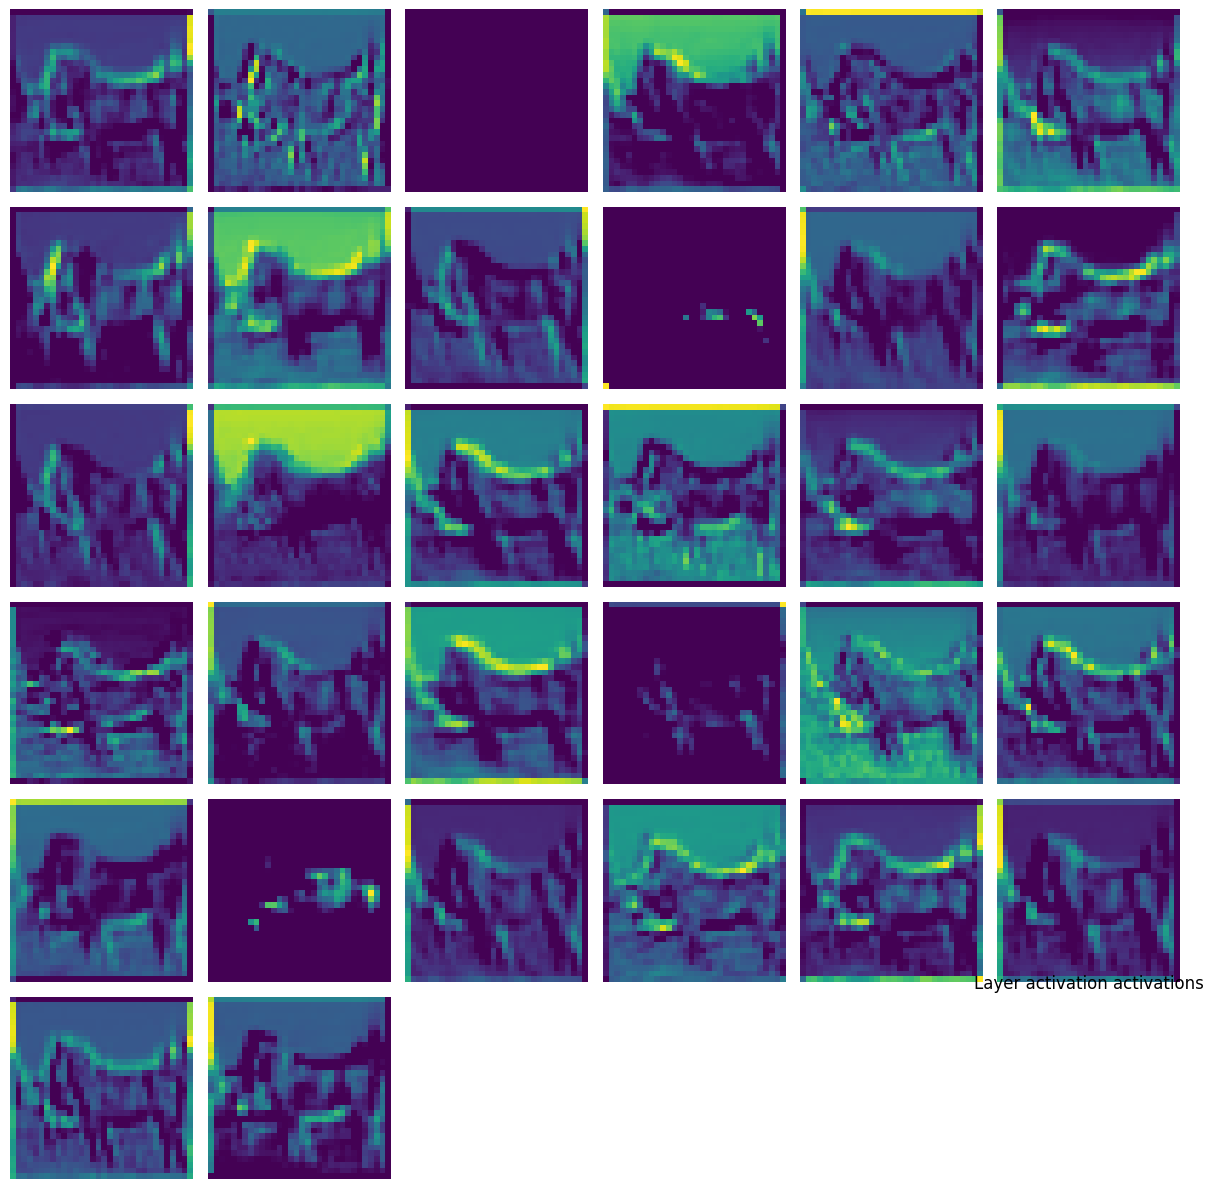

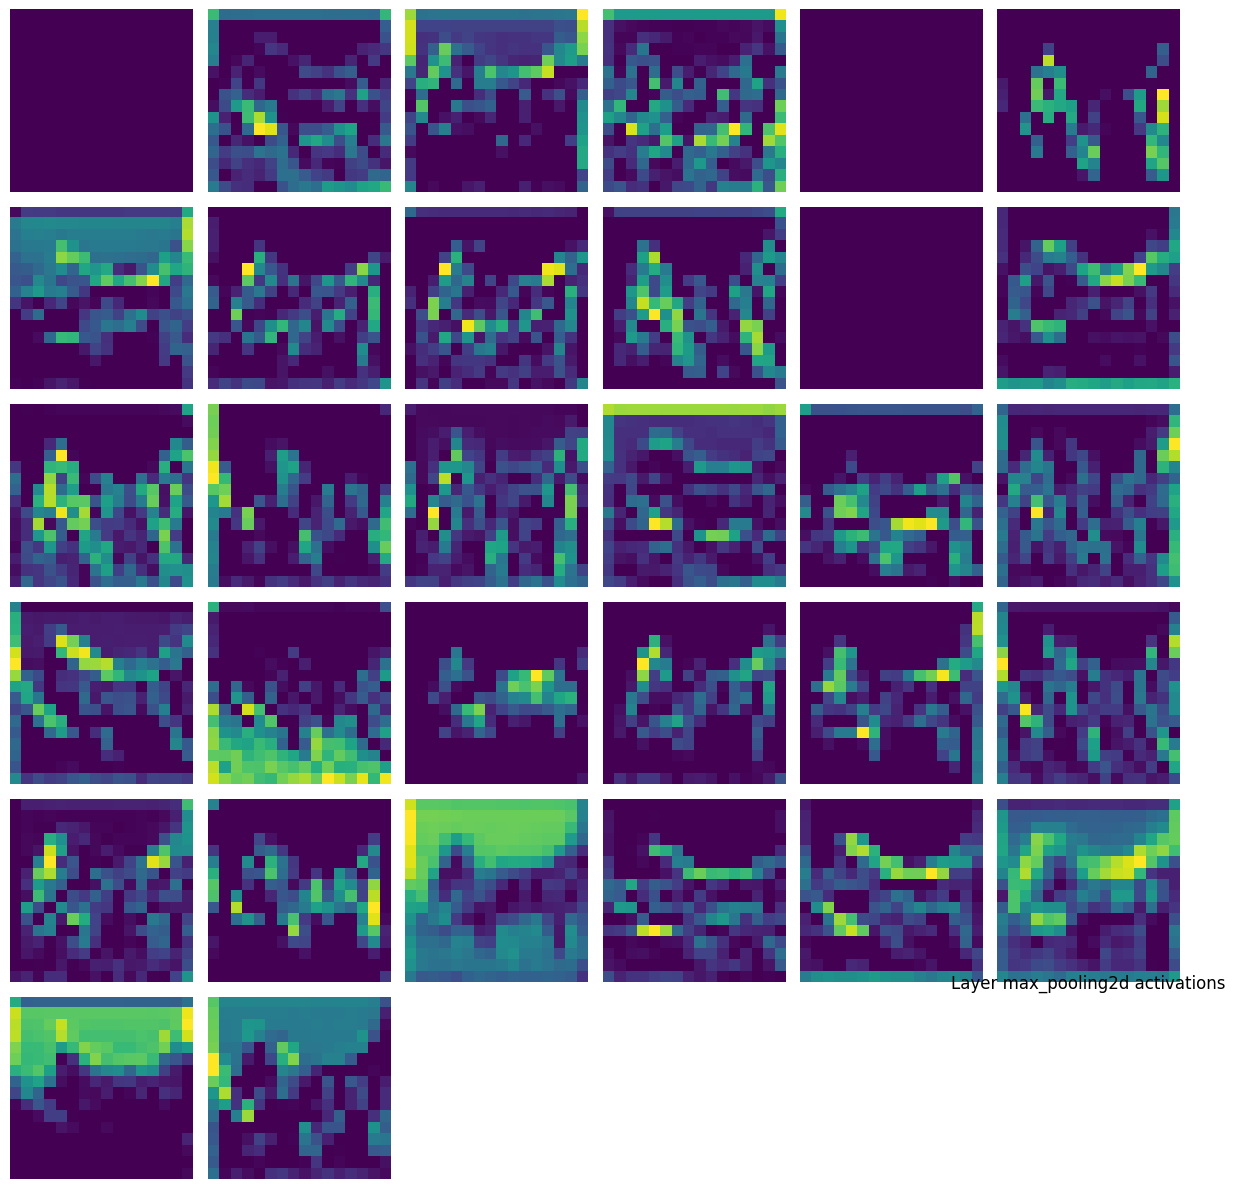

In [15]:
input_img = X_train[12]
input_img = np.expand_dims(input_img, axis=0)

layers_names = ['conv2d', 'activation', 'max_pooling2d']

layer_outputs = [cnn.get_layer(layer_name).output for layer_name in layers_names]
activation_models = Model(inputs=cnn.input, outputs=layer_outputs)

# Get activations
activations = activation_models.predict(input_img)

# Plotting the activations
for layer_activations, layer_name in zip(activations, layers_names):
    num_filters = layer_activations.shape[-1]
    num_cols = int(np.sqrt(num_filters)) if np.sqrt(num_filters).is_integer() else int(np.sqrt(num_filters)) + 1
    fig, axes = plt.subplots(nrows=num_cols, ncols=num_cols, figsize=(12, 12))

    filter_index = 0
    for i in range(num_cols):
        for j in range(num_cols):
            ax = axes[i][j] if num_cols > 1 else axes[j]
            # Only plot if there's an activation map left to plot (for non-perfect squares)
            if filter_index < num_filters:
                ax.imshow(layer_activations[0, :, :, filter_index], cmap='viridis')
                filter_index += 1
                ax.axis('off')
            else:
                ax.axis('off')

    plt.tight_layout()
    plt.title(f'Layer {layer_name} activations')
    plt.show()